In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
assert sklearn.__version__ >= "0.20"
%matplotlib inline

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.5f}".format

from IPython.core.display import display, HTML
import base64
!pip install facets-overview==1.0.0
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator

2021-09-30 20:32:02.178398: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Load the data

In [2]:
train_df = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)

In [3]:
len(train_df)

92092

In [4]:
len(test_df)

10233

In [5]:
print(f"% of train set: {len(train_df)/(len(train_df)+len(test_df)):.2f},\n% of test set: {len(test_df)/(len(train_df)+len(test_df)):.2f}")

% of train set: 0.90,
% of test set: 0.10


## Quick look at the data structure

In [6]:
train_df.head()

name       year game_type  min_players  \
0                Bumeráng-sziget 1986.00000       NaN      1.00000   
1                     Molly Mief 2011.00000       NaN      2.00000   
2                    Micro Arena 2014.00000       NaN      2.00000   
3                Ultra 7 Extreme 2016.00000       NaN      3.00000   
4  Mean Gene's Match-up Football 2010.00000       NaN      1.00000   

   max_players  min_age  min_age_rec  min_time  max_time  \
0      6.00000 10.00000          NaN 120.00000 120.00000   
1      6.00000  6.00000          NaN  10.00000  10.00000   
2      6.00000 10.00000          NaN  30.00000  30.00000   
3      5.00000  7.00000          NaN  15.00000  30.00000   
4      2.00000 10.00000          NaN  90.00000 140.00000   

                            category  \
0                            Wargame   
1  Animals|Children's Game|Real-time   
2                   Fantasy|Fighting   
3                          Card Game   
4                             Sports   

                                            mechanic  cooperative  num_sold  
0  Area Movement|Dice Rolling|Variable Player Powers          NaN   4.00000  
1                                Pattern Recognition          NaN  13.00000  
2                          Action Queue|Dice Rolling          NaN   0.00000  
3                                    Hand Management          NaN   0.00000  
4  Simulation|Solo / Solitaire Game|Stat Check Re...          NaN   3.00000

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92092 entries, 0 to 92091
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         92092 non-null  object 
 1   year         83755 non-null  float64
 2   game_type    19636 non-null  object 
 3   min_players  90386 non-null  float64
 4   max_players  87220 non-null  float64
 5   min_age      71876 non-null  float64
 6   min_age_rec  830 non-null    float64
 7   min_time     72807 non-null  float64
 8   max_time     72807 non-null  float64
 9   category     90199 non-null  object 
 10  mechanic     78141 non-null  object 
 11  cooperative  4630 non-null   float64
 12  num_sold     92092 non-null  float64
dtypes: float64(9), object(4)
memory usage: 9.8+ MB


In [8]:
train_df["category"].value_counts()

Abstract Strategy                                                   4062
Card Game                                                           3646
Wargame|World War II                                                1681
Children's Game                                                     1636
Economic|Negotiation                                                1306
                                                                    ... 
Dice|Medieval|Negotiation                                              1
Card Game|Comic Book / Strip|Educational|Number                        1
Abstract Strategy|Bluffing|Card Game|Collectible Components|Dice       1
Animals|Fantasy|Travel                                                 1
Bluffing|Print & Play|Wargame|World War II                             1
Name: category, Length: 17326, dtype: int64

In [9]:
train_df["name"].value_counts()

Grand Prix                  12
Arena                       10
Robin Hood                  10
Blockade                     9
Siege                        9
                            ..
Fans de Hockey               1
Quick! Put the kettle on     1
Pub Battles: Monmouth        1
Red Herring                  1
Black Path Game              1
Name: name, Length: 88342, dtype: int64

In [10]:
train_df["game_type"].value_counts()

War Game                                            6722
Abstract Game                                       3795
Children's Game                                     3428
Strategy Game                                       1394
Family Game                                         1359
                                                    ... 
Abstract Game|Thematic|Strategy Game                   1
Thematic|Party Game|Family Game                        1
Amiga|Commodore 64|Abstract Game|Arcade|Atari ST       1
Abstract Game|Thematic                                 1
War Game|Party Game                                    1
Name: game_type, Length: 40, dtype: int64

In [11]:
train_df["mechanic"].value_counts()

Roll / Spin and Move                                                                                              6481
Dice Rolling                                                                                                      3696
Hand Management                                                                                                   1765
Set Collection                                                                                                    1721
Hexagon Grid                                                                                                      1646
                                                                                                                  ... 
Hand Management|Race|Simulation                                                                                      1
Action Queue|Movement Template|Player Elimination|Programmed Movement|Simulation|Simultaneous Action Selection       1
Acting|Dice Rolling|Hand Management|Set Collecti

In [12]:
train_df.describe()

year  min_players  max_players     min_age  min_age_rec  \
count 83755.00000  90386.00000  87220.00000 71876.00000    830.00000   
mean   1999.71554      2.03509      6.72572     9.43565      9.90585   
std      73.79636      0.81970     54.65394     8.20224      2.78365   
min   -3500.00000      1.00000      1.00000     1.00000      2.02439   
25%    1995.00000      2.00000      4.00000     7.00000      8.02749   
50%    2009.00000      2.00000      4.00000    10.00000     10.00000   
75%    2016.00000      2.00000      6.00000    12.00000     11.95341   
max    2025.00000     50.00000  11299.00000  2017.00000     20.54167   

          min_time       max_time  cooperative     num_sold  
count  72807.00000    72807.00000   4630.00000  92092.00000  
mean      53.20289      535.19487      0.99611    174.49687  
std      677.95258   111507.05144      0.06224   1575.76273  
min        1.00000        1.00000      0.00000      0.00000  
25%       15.00000       20.00000      1.00000      0.00000  
50%       30.00000       30.00000      1.00000      3.00000  
75%       60.00000       60.00000      1.00000     19.00000  
max   157680.00000 30000000.00000      1.00000 104185.00000

array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'min_players'}>,
        <AxesSubplot:title={'center':'max_players'}>],
       [<AxesSubplot:title={'center':'min_age'}>,
        <AxesSubplot:title={'center':'min_age_rec'}>,
        <AxesSubplot:title={'center':'min_time'}>],
       [<AxesSubplot:title={'center':'max_time'}>,
        <AxesSubplot:title={'center':'cooperative'}>,
        <AxesSubplot:title={'center':'num_sold'}>]], dtype=object)

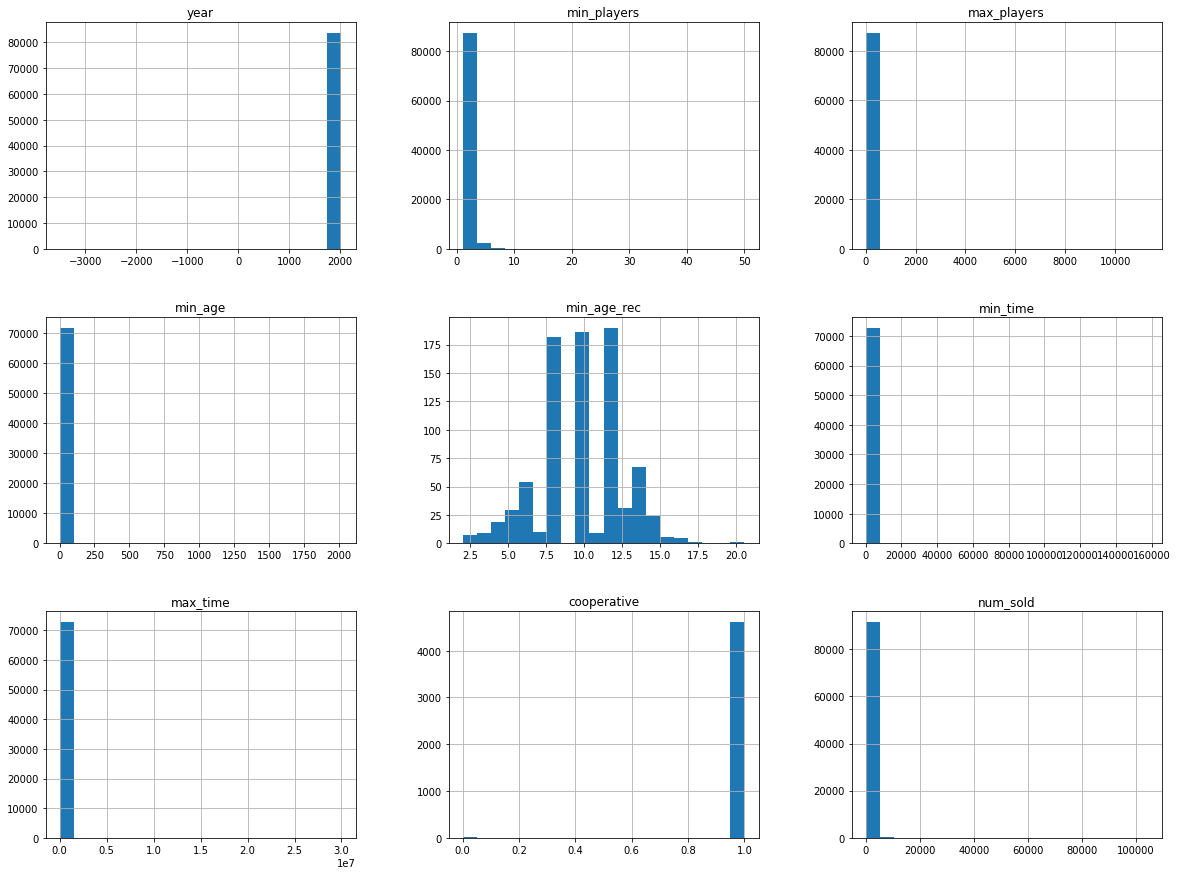

In [13]:
train_df.hist(bins=20, figsize=(20,15))

## Discover and visualize the data

In [14]:
fsg = FeatureStatisticsGenerator()
dataframes = [
    {'table': train_df, 'name': 'trainData'}]
censusProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")


HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

### Looking for correlations

In [15]:
corr_matrix = train_df.corr()

In [16]:
corr_matrix["num_sold"].sort_values(ascending=False)

num_sold       1.00000
min_age_rec    0.04375
min_age        0.02054
cooperative    0.01022
min_time       0.00058
max_time      -0.00050
max_players   -0.00230
min_players   -0.00784
year          -0.00804
Name: num_sold, dtype: float64

<AxesSubplot:xlabel='min_age_rec', ylabel='num_sold'>

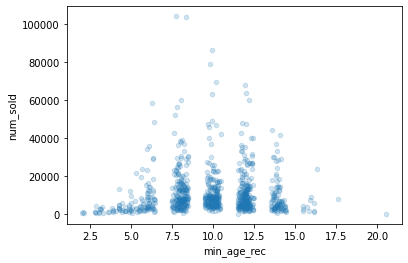

In [17]:
train_df.plot(kind="scatter", x="min_age_rec", y="num_sold", alpha=0.2)

## Prepare the data for machine learning algorithms 

In [18]:
class NumImputer(TransformerMixin):
    def __init__(self):
        self.imputer_cols = [
            {
                "imputer" : SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=1.0),
                "cols" : ["cooperative"]
            },
            {
                "imputer" : SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=-1.0),
                "cols" : ["min_players", "min_age",  "min_time", "max_time", "max_players"]
            },
            {
                "imputer" : SimpleImputer(missing_values=np.nan, strategy="median"),
                "cols" : []
            },
            {
                "imputer" : SimpleImputer(missing_values=np.nan, strategy="mean"),
                "cols" : ["year", "min_age_rec"]
            },
        ]
        
    def fit(self, X, y=None):
        for i in self.imputer_cols:
            if i["cols"]:
                i["imputer"].fit(X[i["cols"]].to_numpy()) if X[i["cols"]].to_numpy().ndim > 1 else i["imputer"].fit(X[i["cols"]].to_numpy().reshape(-1, 1))
        
        return self
    
    def transform(self, X, y=None):
        num_data = []
        for i in self.imputer_cols:
            if i["cols"]:
                num_data.append(i["imputer"].transform(X[i["cols"]].to_numpy())) if X[i["cols"]].to_numpy().ndim > 1 else i["imputer"].transform(X[i["cols"]].to_numpy().reshape(-1, 1))

        return np.concatenate((num_data), axis=1)

In [19]:
class CatTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        self.mlb_cols = {
            "game_type" : MultiLabelBinarizer(),
            "category" : MultiLabelBinarizer(),
            "mechanic" : MultiLabelBinarizer()
        }
    
    def fit(self, X, y=None):
        for (col, mlb) in self.mlb_cols.items():
            mlb.fit(self._preprocess_labels(X[col]))
        return self
    
    def transform(self, X, y=None):
        cat_data = []
        for (col, mlb) in self.mlb_cols.items():
            cat_data.append(mlb.transform(self._preprocess_labels(X[col])))
        return np.concatenate((cat_data), axis=1)
    
    def _preprocess_labels(self, labels):
        return [(l.strip() for l in str(ls).split('|')) for ls in labels.to_numpy()]

In [20]:
num_pipeline = Pipeline([
    ("imputer", NumImputer()),
    ("min_max_scaler", MinMaxScaler()),
])

num_attribs = ["min_players", "max_players", "min_age", "min_age_rec", "min_time", "max_time", "year", "cooperative"]
cat_attribs = ["game_type", "category", "mechanic"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", CatTransformer(), cat_attribs),
])

In [21]:
board_games_prepared = full_pipeline.fit_transform(train_df.drop(["num_sold", "name"], axis=1))

In [22]:
board_games_prepared.shape

(92092, 289)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(board_games_prepared, train_df["num_sold"].to_numpy(), train_size=0.9, random_state=40)

## Select and train Model

### Linear Regression

In [24]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [25]:
lin_predictions = lin_reg.predict(X_test)

In [26]:
lin_mse = mean_squared_error(y_test, lin_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1392.3576778129411

In [27]:
lin_mae = np.abs(y_test - lin_predictions).mean()

In [28]:
lin_mae

299.8965484309901

### KNN

In [29]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [30]:
knn_predictions = knn.predict(X_test)

In [31]:
knn_mse = mean_squared_error(y_test, knn_predictions)
knn_rmse = np.sqrt(knn_mse)
knn_rmse

1364.3439272269766

In [32]:
knn_mae = np.abs(y_test - knn_predictions).mean()
knn_mae

154.25774158523345

### SVR

In [33]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="rbf")
svm_reg.fit(X_train, y_train)

SVR()

In [34]:
svm_predictions = svm_reg.predict(X_test)

In [35]:
svm_mse = mean_squared_error(y_test, svm_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

1487.0925182101955

In [36]:
svm_mae = np.abs(y_test - svm_predictions).mean()
svm_mae

155.0336581601453

### Decision Tree

In [37]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [38]:
tree_reg_predictions = tree_reg.predict(X_test)

In [39]:
tree_mse = mean_squared_error(y_test, tree_reg_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

1475.99289551081

In [40]:
tree_mae = np.abs(y_test - tree_reg_predictions).mean()
tree_mae

159.6399140851095

### Random Forest

In [41]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [42]:
forest_reg_predictions = forest_reg.predict(X_test)

In [43]:
forest_mse = mean_squared_error(y_test, forest_reg_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

957.2464590842421

In [44]:
forest_mae = np.abs(y_test - forest_reg_predictions).mean()
forest_mae

116.32261787735085

## Fine tune model

In [45]:
forest_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [46]:
param_grid = [
    {'bootstrap': [True],
     'ccp_alpha': [0.0],
     'criterion': ['mse'],
     'max_depth': [None],
     'max_features': ['auto'],
     'max_leaf_nodes': [None],
     'max_samples': [None],
     'min_impurity_decrease': [0.0],
     'min_impurity_split': [None],
     'min_samples_leaf': [1],
     'min_samples_split': [2],
     'min_weight_fraction_leaf': [0.0],
     'n_estimators': [100, 200, 300],
     'n_jobs': [None],
     'oob_score': [False],
     'random_state': [None],
     'verbose': [0],
     'warm_start': [False]},
]

In [47]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

In [48]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'bootstrap': [True], 'ccp_alpha': [0.0],
                          'criterion': ['mse'], 'max_depth': [None],
                          'max_features': ['auto'], 'max_leaf_nodes': [None],
                          'max_samples': [None], 'min_impurity_decrease': [0.0],
                          'min_impurity_split': [None], 'min_samples_leaf': [1],
                          'min_samples_split': [2],
                          'min_weight_fraction_leaf': [0.0],
                          'n_estimators': [100, 200, 300], 'n_jobs': [None],
                          'oob_score': [False], 'random_state': [None],
                          'verbose': [0], 'warm_start': [False]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [49]:
grid_search.best_params_

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [50]:
grid_search.best_estimator_

RandomForestRegressor(n_estimators=200)

In [51]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), np.abs(y_test - grid_search.best_estimator_.predict(X_test)).mean(), params, end="\n\n")

1144.6143915598136 117.02865409759221 {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

1136.9550601189242 117.02865409759221 {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

1138.0382631256823 117.02865409759221 {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_featur

## Evaluate model on test set

In [52]:
final_model = grid_search.best_estimator_

In [53]:
X_test_prepared = full_pipeline.transform(test_df)

In [54]:
final_predictions = forest_reg.predict(X_test_prepared)

## Save results

In [55]:
# Save submission
with open('random_forest_3.csv', 'w') as fh:
    fh.write('id,predicted\n')
    for i, y in enumerate(final_predictions):
        fh.write(f'{i},{y}\n')